# Variational Auto-Encoder for MNIST Dataset

Part (i)

In [ ]:
import torchvision as thv
train = thv.datasets.MNIST('./', download=True, train=True) 
val = thv.datasets.MNIST('./', download=True, train=False)
print(train.data.shape, len(train.targets))

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!
torch.Size([60000, 28, 28]) 60000



/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Create a training set of 10,000 images, with approximately equal numbers of samples per class

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
targets = train.targets
train_idx, valid_idx= train_test_split(np.arange(len(targets)), train_size=10000, random_state=42, shuffle=True, stratify=targets)

In [ ]:
x_train, y_train = train.data[train_idx], train.targets[train_idx]

In [ ]:
from collections import Counter
Counter(y_train.numpy())

Counter({0: 987,
         1: 1124,
         2: 993,
         3: 1022,
         4: 974,
         5: 903,
         6: 986,
         7: 1044,
         8: 975,
         9: 992})

Subsample images to 14x14

In [ ]:
x_train, y_train = x_train.numpy(), y_train.numpy()

In [ ]:
#Downsample image size
import cv2
downsampled = []
for im in x_train:
  orig = im.reshape((28,28))
  down = cv2.resize(orig, (14,14)).flatten() #reshape to be one row
  downsampled.extend([down])

In [ ]:
#Now these are the new images we will be working with
x_train = downsampled

Binarize the images so that if a pixel value is greater than 128 set it to 1, otherwise set the pixel value to 0

In [ ]:
for image in x_train:
  one_thresh = 128
  one_threshold_indices = image > one_thresh
  zero_threshold_indices = image <= one_thresh
  image[one_threshold_indices] = 1
  image[zero_threshold_indices] = 0
x_train = np.array(x_train)

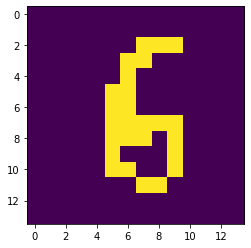

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0,:].reshape(14,14))
plt.show()

Part (ii)

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(14*14, 128)
        self.fc2 = nn.Linear(128,16)
        
    def forward(self, x):
        x1 = torch.tanh(self.fc1(x))
        x2 = self.fc2(x1)
        return x2

If encoder outputs vector of 16, with first 8 entires as the mean and last 8 entires as the standard deviation

input into decoder is a sampling from the multivariate distribution given by the output of the encoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128,196)
        
    def forward(self, x):
        x1 = torch.tanh(self.fc1(x))
        x2 = torch.sigmoid(self.fc2(x1))
        return x2

In [ ]:
from torch.distributions import MultivariateNormal
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        #pass through encoder
        enc_output = self.encoder(x)

        #sample from multivariate normal distribution using encoder output
        #We do this using a parametrization trick whereby we sample from the normal distribution and then multiple the output by the mean and add the variance
        z = MultivariateNormal(torch.zeros(8), torch.eye(8))
        #variance can't be negative, so use torch.exp() and treat output as log(simga)
        dec_input = enc_output[:,0:8] + z.sample()*torch.exp(enc_output[:,8:])
        #pass through decoder
        dec_output = self.decoder(dec_input)
        return enc_output, dec_output

    def decoder_forward(self, z):
      #use to generate images directly
      return self.decoder(z)

Write loss functions

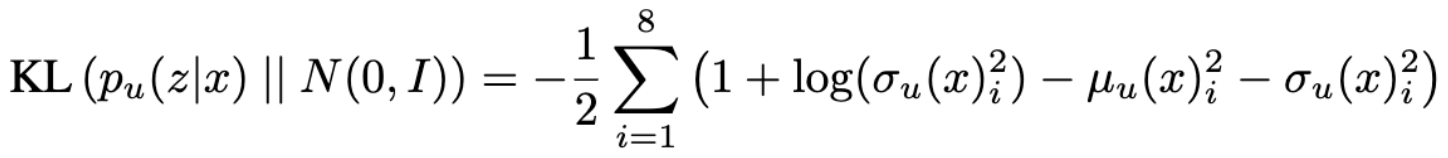

In [ ]:
def KL_divergence(encoder_output, batch_size):
  value = torch.zeros(batch_size)
  mu = encoder_output[:,:8]
  sigma = torch.exp(encoder_output[:,8:])
  for i in range(8):
    value += (1 + torch.log(sigma[:,i]**2) - mu[:,i]**2 - sigma[:,i]**2)
  return (-1/2)*value

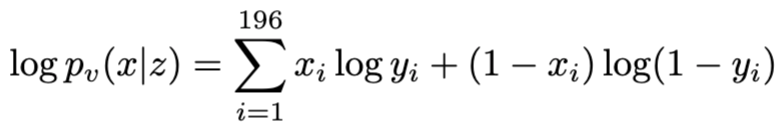

In [ ]:
def log_p_loss(x, y):
  return torch.sum(x*torch.log(y) + (1-x)*torch.log(1-y), dim=1)

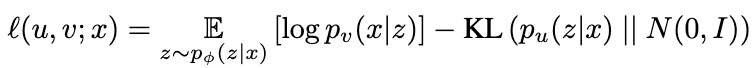

To take the expectation, average over multiple p_v values (expectation is over z so do it for multiple z samples)

Convert images and labels back to torch

In [ ]:
x_train, y_train = torch.from_numpy(x_train), torch.from_numpy(y_train)

In [ ]:
#use as needed
#x_train, y_train = torch.tensor(x_train), torch.tensor(y_train)

Create dataloader objects for batching

In [ ]:
batch_size = 16
trainset = torch.utils.data.TensorDataset(x_train, y_train) # create your datset

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

Create training loop

In [ ]:
def train(train_loader, epochs, model, optimizer, batch_size):
  log_loss_list = []
  KL_list = []

  for e in range(epochs):
    
    for i, (images, labels) in enumerate(trainloader):
      model.train()
      optimizer.zero_grad()
      x = images.float()
      
      #pass through model (Encoder then Decoder)
      y_pred_list = []
      for j in range(2): #we need to sample from multivariate distribution (z) twice to compute the expectation over the log loss term
        enc_output, y_pred = model(x) #where y_pred is output from the decoder
        y_pred_list.append(y_pred)

      #calculate loss
      KL = torch.mean(KL_divergence(enc_output, batch_size))
      log_loss = 0
      for k in range(2): #loss term has expectation around log_loss, so we will use two samples and take the average to approximate this term
        log_loss += torch.mean(log_p_loss(x, y_pred_list[k]))
      avg_log_loss = log_loss / 2
      loss = -(avg_log_loss - KL) #we want to minimize the negative of the ELBO loss
      loss = torch.mean(loss)
      log_loss_list.append(avg_log_loss)
      KL_list.append(KL)
      if (i+1) % 200 == 0:
        print("Epoch: {}".format(e+1), "Loss: {}".format(loss))

      #propagate loss backwards
      loss.backward()
      optimizer.step()
  
  return log_loss_list, KL_list

Train the network

In [ ]:
import torch.optim as optim

model = EncoderDecoder(Encoder(), Decoder())
epochs = 10
optimizer = optim.Adam(model.parameters(), lr=0.001)

log_loss_list, KL_list = train(x_train, epochs, model, optimizer, batch_size)

Epoch: 1 Loss: 55.26042556762695
Epoch: 1 Loss: 48.620933532714844
Epoch: 1 Loss: 46.531402587890625
Epoch: 2 Loss: 43.42424011230469
Epoch: 2 Loss: 43.76069259643555
Epoch: 2 Loss: 41.02793502807617
Epoch: 3 Loss: 39.37825393676758
Epoch: 3 Loss: 40.289794921875
Epoch: 3 Loss: 42.21944808959961
Epoch: 4 Loss: 36.87077713012695
Epoch: 4 Loss: 36.995697021484375
Epoch: 4 Loss: 37.26888656616211
Epoch: 5 Loss: 40.485755920410156
Epoch: 5 Loss: 40.666542053222656
Epoch: 5 Loss: 33.71499252319336
Epoch: 6 Loss: 39.20759582519531
Epoch: 6 Loss: 36.96833419799805
Epoch: 6 Loss: 37.834163665771484
Epoch: 7 Loss: 32.560306549072266
Epoch: 7 Loss: 41.14329528808594
Epoch: 7 Loss: 36.840694427490234
Epoch: 8 Loss: 29.0850830078125
Epoch: 8 Loss: 36.011474609375
Epoch: 8 Loss: 35.416351318359375
Epoch: 9 Loss: 39.00190734863281
Epoch: 9 Loss: 42.680686950683594
Epoch: 9 Loss: 39.5067253112793
Epoch: 10 Loss: 38.559993743896484
Epoch: 10 Loss: 32.649505615234375
Epoch: 10 Loss: 31.441448211669922


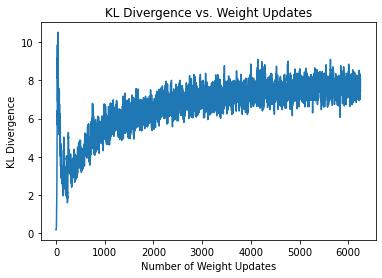

In [ ]:
import matplotlib.pyplot as plt
plt.plot(KL_list)
plt.xlabel('Number of Weight Updates')
plt.ylabel('KL Divergence')
plt.title('KL Divergence vs. Weight Updates')
plt.show()

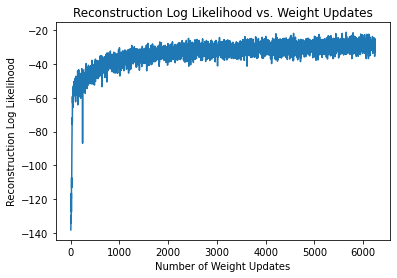

In [ ]:
plt.plot(log_loss_list)
plt.xlabel('Number of Weight Updates')
plt.ylabel('Reconstruction Log Likelihood')
plt.title('Reconstruction Log Likelihood vs. Weight Updates')
plt.show()

Pick 8 MNIST images and reconstruct their images in one pass of the model by using a mini-batch size of 8

In [ ]:
model.eval()
_, y_pred = model(x_train[:8,:].float())
new_x = y_pred.detach().numpy()

In [ ]:
new_x, x_train = np.array(new_x), x_train.numpy()

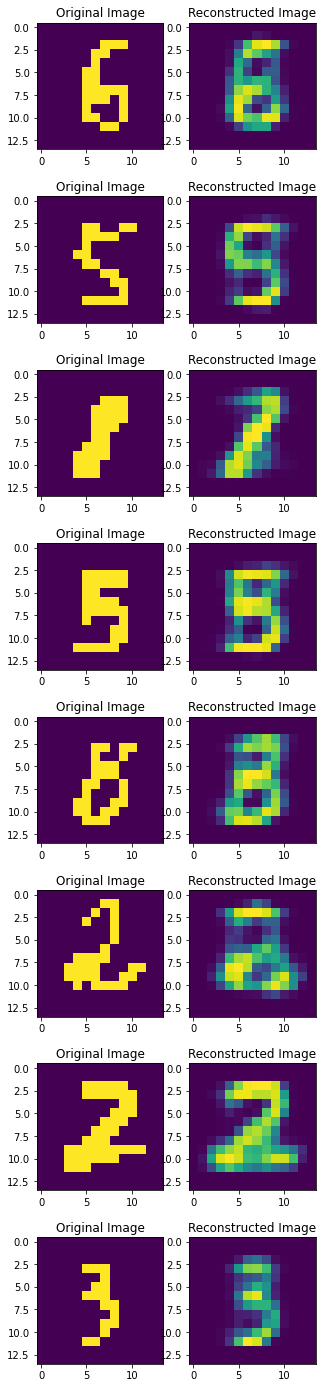

In [ ]:
fig = plt.figure(figsize=(5,25))
j=0
k=0

for i in range(16):
  plt.subplot(8, 2, i+1)
  #alternate plotting index to get images side by side
  if (i+1)%2==0:
    plt.title('Reconstructed Image')    
    plt.imshow(new_x[j].reshape(14,14))
    j+=1
  else:
    plt.title('Original Image')
    plt.imshow(x_train[k].reshape(14,14))
    k+=1

Sample z directly and generate an image by passing z through the decoder

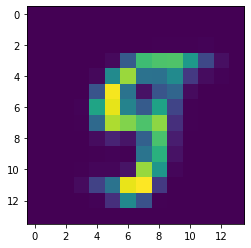

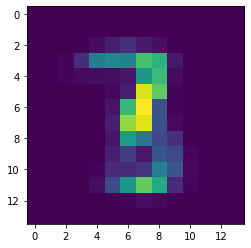

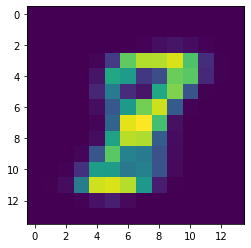

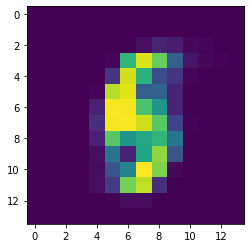

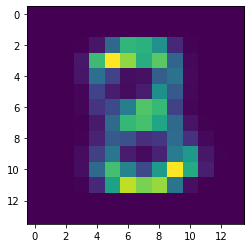

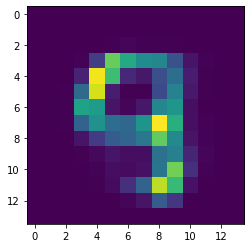

In [ ]:
for i in range(6):
  z = MultivariateNormal(torch.zeros(8), torch.eye(8))
  generated_image = model.decoder_forward(z.sample())
  plt.imshow(generated_image.detach().numpy().reshape(14,14))
  plt.show()